## 평가문항
1. 인물모드 사진을 성공적으로 제작하였다.   
아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.   
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.   
추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 시맨틱 세그멘테이션
세그멘테이션으로 사람 분리하기

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [35]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hansohi.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(538, 480, 3)


In [36]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(538, 480, 3) (513, 457, 3) 15


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

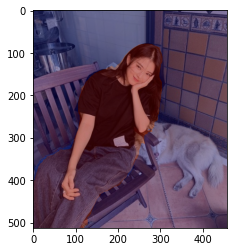

In [37]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

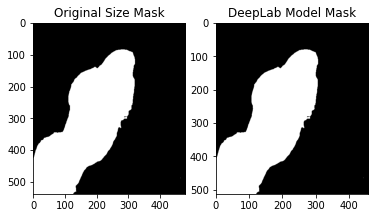

In [38]:
### 세그멘테이션 결과를 원래 크기로 복원하기
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

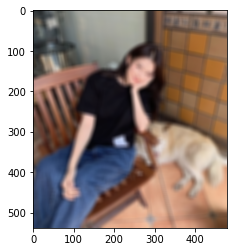

In [39]:
### 배경흐리게 하기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

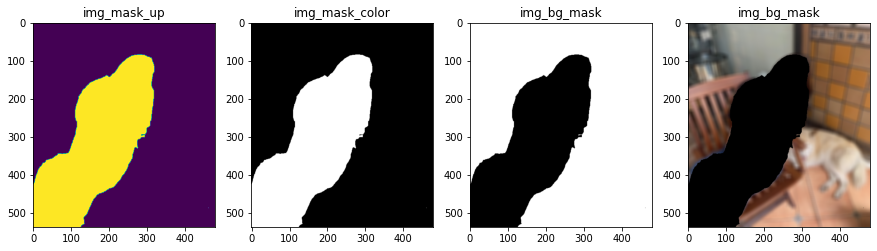

In [40]:
### 마스크 과정 살펴보기
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

## 인물1

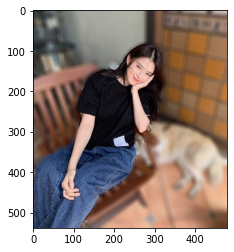

In [41]:
### 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 문제점
- 오른쪽 팔 밑에 강아지가 블러처리가 되지 않았다. 세세하게 윤곽이 추출되지 않았다는 뜻이된다.

#### <배경합성>
크로마키로 합성한 것은 아니다. 사실 될줄 몰랐다. 정말이다....   
크로마키 합성이란 기법을 사용하기 전에 합성에 대해 든 생각은 "x와 y의 길이만 맞춰주면 합성이 되지 않을까?"였다.   
이미지를 비율대로 맞춰서 합성하려 했으나, 이미지가 너무 상이해서 crop하여 합성하였다.

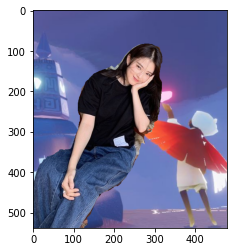

In [45]:
img_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sky1.jpg'
img_bg_orig = cv2.imread(img_bg_path) 
img_cropped_bg_orig = img_bg_orig[1000: 1000 + 538, 1000: 1000 + 480]

img_concat = np.where(img_mask_color==255, img_orig, img_cropped_bg_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 인물2 (사실은 고양이...)

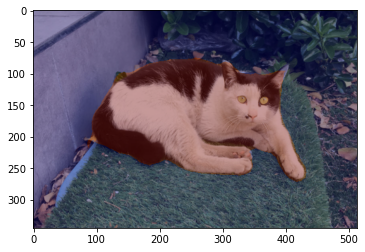

In [14]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

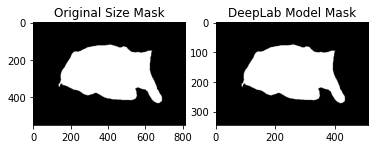

In [15]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

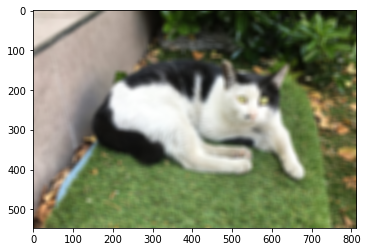

In [16]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

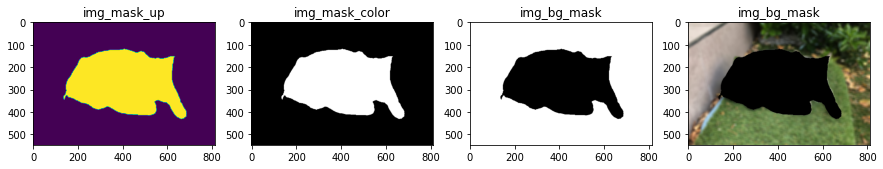

In [17]:
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

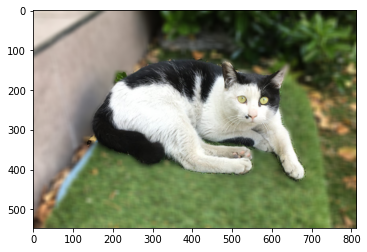

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 문제점
- 고양이 꼬리 왼쪽의 조그마한 나뭇잎도 같이 추출이 되었다.
- 고양이 두 다리와 두 팔 사이의 잔디부분도 고양이와 같이 추출되어 블러처리가 되지 않았다.

#### <배경합성>

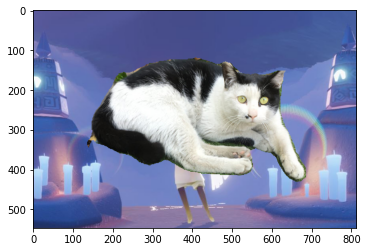

In [20]:
img_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sky1.jpg'
img_bg_orig = cv2.imread(img_bg_path) 
img_cropped_bg_orig = img_bg_orig[1000: 1000 + 547, 1000: 1000 + 813]

img_concat = np.where(img_mask_color==255, img_orig, img_cropped_bg_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

사실 배경합성 될줄 몰랐다... 정말이다... 크로마키 합성은 아니지만.... 합성은 되었다...

## 인물 3 . (사실은 갱얼쥐...)

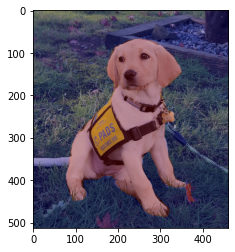

In [21]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 강아지만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

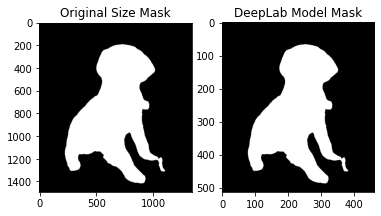

In [22]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

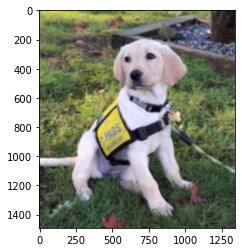

In [23]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

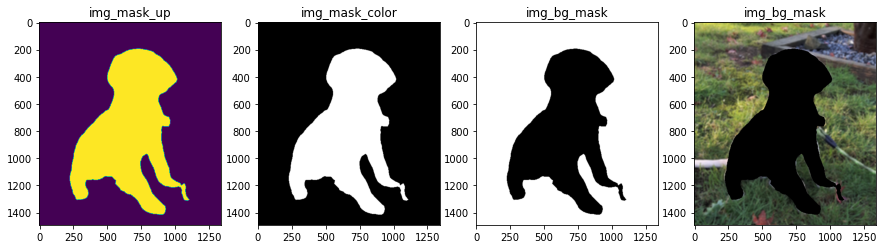

In [24]:
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

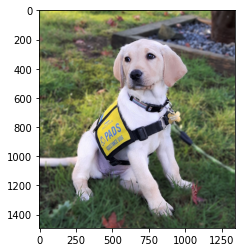

In [25]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 문제점
- 꼬리 부분도 추출해야 하는데 추출이 되지 않고 블러처리가 되었다.
- 나뭇잎(단풍잎?)부분이 강아지라고 인식이 되어 추출이 되었다.

#### <배경합성>
크로마키 합성은 아니다. 하지만 합성이 되었다.
이미지를 비율대로 줄일려고 했으나 x길이와 y의 길이가 갱얼쥐 사진이랑 맞지 않아서 crop하고 합성해버렸다.

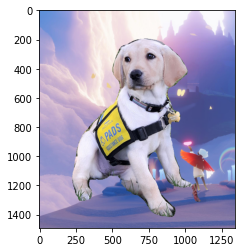

In [33]:
img_bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sky1.jpg'
img_bg_orig = cv2.imread(img_bg_path) 
img_cropped_bg_orig = img_bg_orig[300: 300 + 1491, 300: 300 + 1341]

img_concat = np.where(img_mask_color==255, img_orig, img_cropped_bg_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

-----
## 회고? 및 정리 및 솔루션 제시(?)

우선 object의 윤곽을 추출할 때 섬세하지 못하다는 것이 느껴졌지만, 자동으로 해주는데(?) 이정도 퀄리티면 괜찮은 것 같기도 하다는 생각이 들었다.   
아무래도 포토샵으로 윤곽을 추출하는 것보단 덜 섬세할 수 도 있다는 것이 아직 보완해야될 부분인 것이 느껴졌다.   
object가 충분히 인식 될 수 있게 배경과의 색상이나 조명등의 구분이 확실히 잘되어야지 추출이 용이하다는 것을 알아냈다.

해결방안은 그저 조명이나 색상, gray scale등 을 이용해서 object와 배경간의 차이를 확실히 해주는 것이 추출성능이 훨씬 올라갈 것이다.